This is a guided example referencing https://github.com/andrewwlong/diabetes_readmission/blob/master/diabetes_project.ipynb  
Confusion Matrix reference https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

### Load Data

In [53]:
data = pd.read_csv('diabetic_data.csv', na_values = '?')
data.info()

C:\Users\andre\OneDrive\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# Data Preparation

### Remove Discharge IDs relating to Hospice or Death

In [54]:
data = data.loc[~data.discharge_disposition_id.isin([11,13,14,18,20,21])]

### Create Target Variable

In [55]:
data['Target_Label'] = (data.readmitted == '<30').astype(int)

### Numerical Predictors

In [56]:
num_col_names = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',\
                 'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

### Categorical Predictors

In [57]:
cat_col_names = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',\
                 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',\
                 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',\
                 'miglitol', 'troglitazone','tolazamide', 'insulin', 'glyburide-metformin',\
                 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',\
                 'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

# Fill NA with 'UNK'
data['race'] = data['race'].fillna('UNK')
data['payer_code'] = data['payer_code'].fillna('UNK')
data['medical_specialty'] = data['medical_specialty'].fillna('UNK')

# Get top 10 medical specialties
top_10_spec = list(data['medical_specialty'].value_counts(dropna=False)[0:10].index)

# New medical_specialty column
data['med_spec_new'] = data['medical_specialty'].copy()

# Replace values with 'Other' if not in Top 10
data.loc[~data.med_spec_new.isin(top_10_spec), 'med_spec_new'] = 'Other'

# Convert Numerical Categorical Columns to strings
cat_col_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
data[cat_col_num] = data[cat_col_num].astype(str)

# Create Categorical Predictors DataFrame
data_cat = pd.get_dummies(data[cat_col_names + cat_col_num + ['med_spec_new']], drop_first = True)

data_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_new_Emergency/Trauma,med_spec_new_Family/GeneralPractice,med_spec_new_InternalMedicine,med_spec_new_Nephrology,med_spec_new_Orthopedics,med_spec_new_Orthopedics-Reconstructive,med_spec_new_Other,med_spec_new_Radiologist,med_spec_new_Surgery-General,med_spec_new_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [58]:
# Add Categorical Predictor Variables to main DataFrame
data = pd.concat([data, data_cat], axis = 1)

# Retain columns of data_cat
data_cat_cols = list(data_cat.columns)

### Features

In [59]:
# Create Age Group Variable
age_dict = {'[0-10)':0, 
            '[10-20)':10, 
            '[20-30)':20, 
            '[30-40)':30, 
            '[40-50)':40, 
            '[50-60)':50,
            '[60-70)':60, 
            '[70-80)':70, 
            '[80-90)':80, 
            '[90-100)':90}
data['age_group'] = data.age.replace(age_dict)

# Create Age Variable
data['has_weight'] = data.weight.notnull().astype('int')

# Save feature names
features = ['age_group', 'has_weight']

### Summary of Variables for Modeling

In [60]:
print('Total number of predictors:', len(num_col_names + data_cat_cols + features))
print('Numerical predictors:',len(num_col_names))
print('Categorical predictors:',len(data_cat_cols))
print('Features:',len(features))

Total number of predictors: 142
Numerical predictors: 8
Categorical predictors: 132
Features: 2


In [61]:
# Check Missing Data
data[num_col_names + data_cat_cols + features].isnull().sum().sort_values(ascending=False)

has_weight                     0
pioglitazone_No                0
acarbose_No                    0
rosiglitazone_Up               0
rosiglitazone_Steady           0
                              ..
discharge_disposition_id_2     0
discharge_disposition_id_22    0
discharge_disposition_id_23    0
discharge_disposition_id_24    0
time_in_hospital               0
Length: 142, dtype: int64

In [62]:
# Dataframe for modeling
model_data = data[num_col_names + data_cat_cols + features + ['Target_Label']]

# Modeling Prep

### Split Data

In [63]:
# Shuffle Data
model_data = model_data.sample(n=len(model_data),random_state=10)
model_data = model_data.reset_index(drop=True)

# 15% Validation / 15% Test split / 70% Train
vd_test = model_data.sample(frac=0.3, random_state=10)
test_data = vd_test.sample(frac=0.5, random_state=10)
vd_data = vd_test.drop(test_data.index)
train_data = model_data.drop(vd_test.index)

In [64]:
print('Readmission Rates by Set')
print('Test: ', test_data[test_data['Target_Label']==1].shape[0]/test_data.shape[0])
print('Validation: ', vd_data[vd_data['Target_Label']==1].shape[0]/vd_data.shape[0])
print('Train: ', train_data[train_data['Target_Label']==1].shape[0]/train_data.shape[0])

Readmission Rates by Set
Test:  0.1140149139312844
Validation:  0.11749947731549237
Train:  0.11249663988530809


### Balance Training Data

In [65]:
# Split training data into positive and negative
positive = train_data.Target_Label == 1
train_data_pos = train_data.loc[positive]
train_data_neg = train_data.loc[~positive]

# Merge and Balance
train_data_balanced = pd.concat([train_data_pos, train_data_neg.sample(n = len(train_data_pos), random_state=10)], axis = 0)

# Shuffle
train_data_balanced = train_data_balanced.sample(n = len(train_data_balanced), random_state = 10).reset_index(drop=True)

print('Readmission Rates by Set')
print('Test: ', test_data[test_data['Target_Label']==1].shape[0]/test_data.shape[0])
print('Validation: ', vd_data[vd_data['Target_Label']==1].shape[0]/vd_data.shape[0])
print('Train: ', train_data[train_data['Target_Label']==1].shape[0]/train_data.shape[0])
print('Train Balanced: ', train_data_balanced[train_data_balanced['Target_Label']==1].shape[0]/train_data_balanced.shape[0])

Readmission Rates by Set
Test:  0.1140149139312844
Validation:  0.11749947731549237
Train:  0.11249663988530809
Train Balanced:  0.5


### Create Input Matrices and Output Vectors

In [66]:
train_matrix = train_data[num_col_names + data_cat_cols + features].values
train_balanced_matrix = train_data_balanced[num_col_names + data_cat_cols + features].values
vd_matrix = vd_data[num_col_names + data_cat_cols + features].values

train_labels = train_data_balanced['Target_Label'].values
vd_labels = vd_data['Target_Label'].values

print('Training Matrix:',train_matrix.shape)
print('Balanced Training Matrix, Label:',train_balanced_matrix.shape, train_labels.shape[0])
print('Validation Matrix, Label:',vd_matrix.shape, vd_labels.shape[0])

Training Matrix: (66962, 142)
Balanced Training Matrix, Label: (15066, 142) 15066
Validation Matrix, Label: (14349, 142) 14349


### Scaling

In [67]:
scaler = StandardScaler()
scaler.fit(train_matrix)

scaled_train = scaler.transform(train_balanced_matrix)
scaled_vd = scaler.transform(vd_matrix)

# Modeling

In [68]:
def report(actual, predicted):
    AUC = roc_auc_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    print('AUC: ', AUC)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('Confusion Matrix:')
    conf_matrix = confusion_matrix(actual, predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    return AUC, accuracy, precision, recall

### K Nearest Neighbors

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(scaled_train, train_labels)

KNeighborsClassifier(n_neighbors=100)

Train:
AUC:  0.5581441656710474
Accuracy:  0.5581441656710474
Precision:  0.5342562177381511
Recall:  0.9068100358422939
Confusion Matrix:


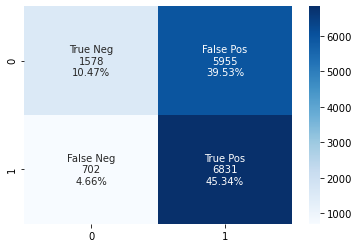

In [50]:
train_predictions = knn.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.4] = 1
train_predictions[train_predictions <= 0.4] = 0
print('Train:')
knn_train_AUC, knn_train_accuracy, knn_train_precision, knn_train_recall = report(train_labels, train_predictions)

Validation:
AUC:  0.5392664003037403
Accuracy:  0.2734685343926406
Precision:  0.12746184670474892
Recall:  0.8867141162514828
Confusion Matrix:


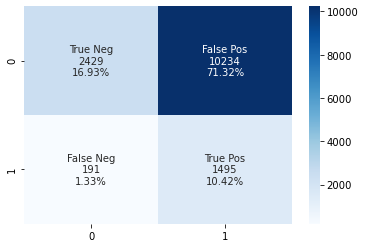

In [51]:
vd_predictions = knn.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.4] = 1
vd_predictions[vd_predictions <= 0.4] = 0
print('Validation:')
knn_vd_AUC, knn_vd_accuracy, knn_vd_precision, knn_vd_recall = report(vd_labels, vd_predictions)

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=10)
logistic_regression.fit(scaled_train, train_labels)

C:\Users\andre\OneDrive\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=10)

Train:
AUC:  0.6209345546263109
Accuracy:  0.6209345546263109
Precision:  0.6392114914425427
Recall:  0.5552900570821718
Confusion Matrix:


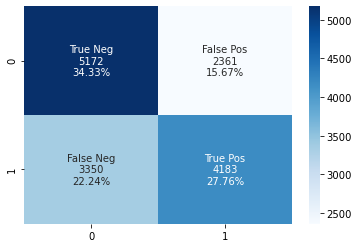

In [24]:
train_predictions = logistic_regression.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
lr_train_AUC, lr_train_accuracy, lr_train_precision, lr_train_recall = report(train_labels, train_predictions)

Validation:
AUC:  0.6184189485830746
Accuracy:  0.6631821032824587
Precision:  0.1874875868917577
Recall:  0.5599051008303677
Confusion Matrix:


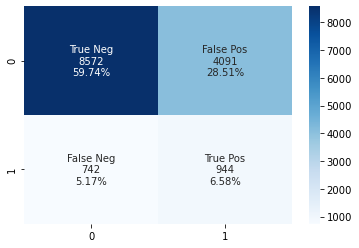

In [25]:
vd_predictions = logistic_regression.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
lr_vd_AUC, lr_vd_accuracy, lr_vd_precision, lr_vd_recall = report(vd_labels, vd_predictions)

### Stochastic Gradient Descent

In [26]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = 'log', alpha = 0.1, random_state=10)
sgd.fit(scaled_train, train_labels)

SGDClassifier(alpha=0.1, loss='log', random_state=10)

Train:
AUC:  0.6154918359219436
Accuracy:  0.6154918359219435
Precision:  0.6329868541730358
Recall:  0.5497145891411125
Confusion Matrix:


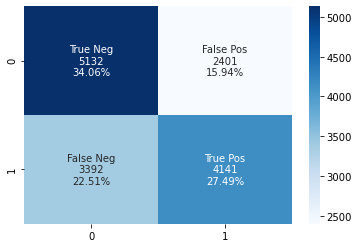

In [27]:
train_predictions = sgd.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
sgd_train_AUC, sgd_train_accuracy, sgd_train_precision, sgd_train_recall = report(train_labels, train_predictions)

Validation:
AUC:  0.6189725832791642
Accuracy:  0.6632517945501428
Precision:  0.18777292576419213
Recall:  0.561091340450771
Confusion Matrix:


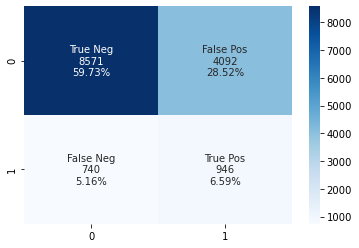

In [28]:
vd_predictions = sgd.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
sgd_vd_AUC, sgd_vd_accuracy, sgd_vd_precision, sgd_vd_recall = report(vd_labels, vd_predictions)

### Naive Bayes

In [29]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(scaled_train, train_labels)

GaussianNB()

Train:
AUC:  0.5031196070622594
Accuracy:  0.5031196070622594
Precision:  0.5015755950385518
Recall:  0.9930970396920218
Confusion Matrix:


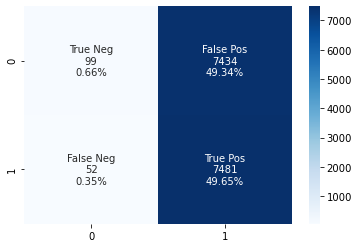

In [30]:
train_predictions = nb.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
nb_train_AUC, nb_train_accuracy, nb_train_precision, nb_train_recall = report(train_labels, train_predictions)

Validation:
AUC:  0.5019305550988772
Accuracy:  0.1254442818314865
Precision:  0.11790362293352093
Recall:  0.9940688018979834
Confusion Matrix:


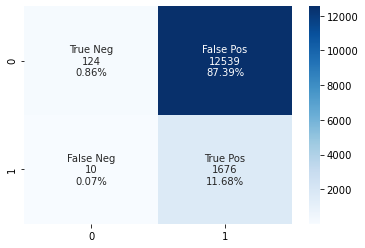

In [31]:
vd_predictions = nb.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
nb_vd_AUC, nb_vd_accuracy, nb_vd_precision, nb_vd_recall = report(vd_labels, vd_predictions)

### Decision Tree Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 10, random_state = 10)
dt.fit(scaled_train, train_labels)

DecisionTreeClassifier(max_depth=10, random_state=10)

Train:
AUC:  0.6669985397583964
Accuracy:  0.6669985397583964
Precision:  0.693717277486911
Recall:  0.5980353112969601
Confusion Matrix:


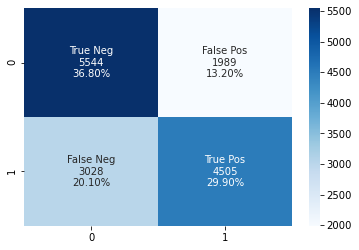

In [33]:
train_predictions = dt.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
dt_train_AUC, dt_train_accuracy, dt_train_precision, dt_train_recall = report(train_labels, train_predictions)

Validation:
AUC:  0.6003523308723286
Accuracy:  0.6548888424280438
Precision:  0.17663366336633662
Recall:  0.5290628706998813
Confusion Matrix:


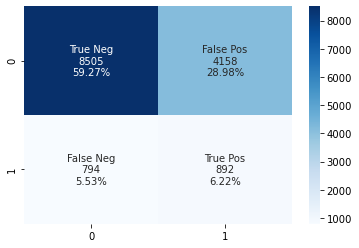

In [34]:
vd_predictions = dt.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
dt_vd_AUC, dt_vd_accuracy, dt_vd_precision, dt_vd_recall = report(vd_labels, vd_predictions)

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 10)
rf.fit(scaled_train, train_labels)

RandomForestClassifier(max_depth=6, random_state=10)

Train:
AUC:  0.6388557015797158
Accuracy:  0.6388557015797159
Precision:  0.6471167369901547
Recall:  0.6107792380193814
Confusion Matrix:


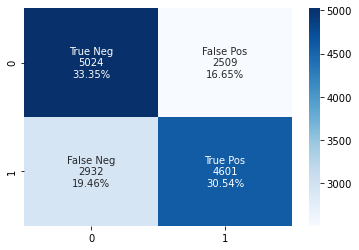

In [36]:
train_predictions = rf.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
rf_train_AUC, rf_train_accuracy, rf_train_precision, rf_train_recall = report(train_labels, train_predictions)

Validation:
AUC:  0.6181459954365887
Accuracy:  0.6377447905777406
Precision:  0.18130671506352086
Recall:  0.5925266903914591
Confusion Matrix:


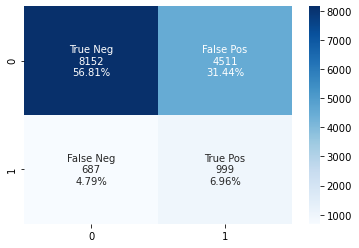

In [37]:
vd_predictions = rf.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
rf_vd_AUC, rf_vd_accuracy, rf_vd_precision, rf_vd_recall = report(vd_labels, vd_predictions)

### Gradient Boosting Classifier

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=75, learning_rate=1.0, max_depth=3, random_state=42)
gbc.fit(scaled_train, train_labels)

GradientBoostingClassifier(learning_rate=1.0, n_estimators=75, random_state=42)

Train:
AUC:  0.6806717111376609
Accuracy:  0.680671711137661
Precision:  0.6913129041326961
Recall:  0.6528607460507102
Confusion Matrix:


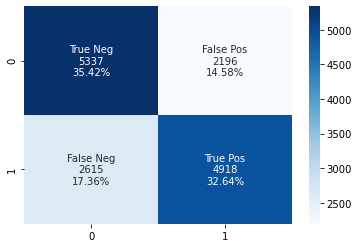

In [82]:
train_predictions = gbc.predict_proba(scaled_train)[:,1]
train_predictions[train_predictions > 0.5] = 1
train_predictions[train_predictions <= 0.5] = 0
print('Train:')
gbc_train_AUC, gbc_train_accuracy, gbc_train_precision, gbc_train_recall = report(train_labels, train_predictions)

Validation:
AUC:  0.6116502726159071
Accuracy:  0.6267335702836434
Precision:  0.17613836921990822
Recall:  0.5919335705812574
Confusion Matrix:


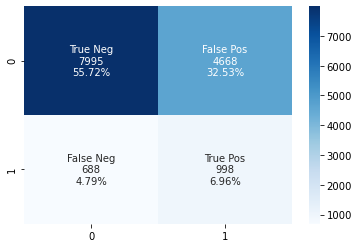

In [83]:
vd_predictions = gbc.predict_proba(scaled_vd)[:,1]
vd_predictions[vd_predictions > 0.5] = 1
vd_predictions[vd_predictions <= 0.5] = 0
print('Validation:')
gbc_vd_AUC, gbc_vd_accuracy, gbc_vd_precision, gbc_vd_recall = report(vd_labels, vd_predictions)